# Example 14: Protein Sequence Classification

In this example, we will see how to use KAN in protein sequence classification. We will be using one hot encoding to encode the amino acids.

#### This is just an example how it can be used for protein sequences. Need to use real data to actually observe the performance.

In [1]:
from kan import *
import torch
import random
import numpy as np

In [ ]:
# Pre Processing

import pandas as pd
!pip install dmba
!pip install pykan

df = pd.read_csv('DataCoSupplyChainDataset.csv', header=0, encoding='unicode_escape')
df
df.shape
df.info()
df.isnull().sum()
df['Cust_Full_Name'] = df['Customer Fname'].astype(str) + df['Customer Lname'].astype(str)
df.select_dtypes(include=['object']).describe()
# Data Cleaning
data = df.copy()
data.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname',
         'Customer Lname','Latitude','Longitude','Product Description','Product Image','Order Zipcode',
         'shipping date (DateOrders)'],axis=1, inplace = True)
data
data.isnull().sum()
#Deopping unnecessary values
data = data.dropna(subset=['Product Price', 'Shipping Mode'])
#using order date to get the date in year month week and hrs.

data['order date (DateOrders)'].head()


## Splitting Order dates and creating new columns
df['order_yr']= pd.DatetimeIndex(df['order date (DateOrders)']).year
df['order_month'] = pd.DatetimeIndex(df['order date (DateOrders)']).month
df['order_day'] = pd.DatetimeIndex(df['order date (DateOrders)']).weekday
df['order_hour'] = pd.DatetimeIndex(df['order date (DateOrders)']).hour
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visual style for the plots
sns.set(style="whitegrid")

# Step 1: Distribution of Key Numerical Variables
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Histogram of Days for shipping (real)
sns.histplot(data, x='Days for shipping (real)', kde=True, ax=axs[0])
axs[0].set_title('Distribution of Days for Shipping (Real)')

# Histogram of Benefit per order
sns.histplot(data, x='Benefit per order', kde=True, ax=axs[1])
axs[1].set_title('Distribution of Benefit per Order')

# Histogram of Sales per Customer
sns.histplot(data, x='Sales per customer', kde=True, ax=axs[2])
axs[2].set_title('Distribution of Sales per Customer')

# Step 2: Categorical Data Analysis (in subsequent cells due to plot size considerations)
plt.tight_layout()
plt.show()

#  Categorical Data Analysis
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Bar plot of Delivery Status
sns.countplot(data, y='Delivery Status', order=data['Delivery Status'].value_counts().index, ax=axs[0])
axs[0].set_title('Frequency of Delivery Status')

# Bar plot of Category Name
sns.countplot(data, y='Category Name',  order=data['Category Name'].value_counts().index, ax=axs[1])
axs[1].set_title('Frequency of Category Names')

# Bar plot of Customer Segment
sns.countplot(data, y='Customer Segment',  order=data['Customer Segment'].value_counts().index, ax=axs[2])
axs[2].set_title('Frequency of Customer Segments')

plt.tight_layout()
plt.show()

#  Outliers Detection
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Boxplot for Days for shipping (real)
sns.boxplot(data, x='Days for shipping (real)', ax=axs[0])
axs[0].set_title('Boxplot of Days for Shipping (Real)')

# Boxplot for Benefit per order
sns.boxplot(data, x='Benefit per order', ax=axs[1])
axs[1].set_title('Boxplot of Benefit per Order')

# Boxplot for Sales per customer
sns.boxplot(data, x='Sales per customer', ax=axs[2])
axs[2].set_title('Boxplot of Sales per Customer')

plt.tight_layout()
plt.show()
# Correlation Matrix
correlation_matrix = data.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# We will create a baseline for loss if the Benifit per order is less than 0

loss = data[data['Benefit per order']<0]
loss['Category Name'].value_counts().nlargest(10)

loss['Market'].value_counts().nlargest(10)

# Setting up the figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 9))  # Adjusting the size for better visibility

# Plotting the Most Loss Making Products
loss['Category Name'].value_counts().nlargest(10).plot.bar(ax=axs[0])
axs[0].set_title("Most Loss Making Products")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)


# Plotting the Most Loss Making Markets
loss['Market'].value_counts().nlargest(10).plot.bar(ax=axs[1])
axs[1].set_title("Most Loss Making Market")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Grouping order status by payment type

status = data.groupby('Type')['Order Status'].value_counts()

status_df = pd.DataFrame(status)

status_df
# Now using the suspected fraud to know the products with most fraud cases

fraud_region = data[data['Order Status'] == 'SUSPECTED_FRAUD']
# Getting the counts of the top 10 categories
temp = fraud_region['Category Name'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))  # Setting the figure size

# Creating the bar plot
temp.plot(kind='bar')

# Adding titles and labels
plt.title('Top 10 Product Categories with Suspected Fraud')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotating the x-ticks for better readability

# Displaying the plot
plt.show()
# Prepping Data for Modeling
main_df = data.sample(n=1000, random_state=1)
import numpy as np

main_df['flagged'] = np.where(main_df['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)


main_df
main_df['flagged'].value_counts()
main_df.isnull().sum()
# Drop rows where 'Customer Zipcode' is NaN
main_df = main_df.dropna(subset=['Customer Zipcode'])
main_df['flagged'].value_counts()
main_df.columns
# Identify categorical columns
categorical_cols = main_df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)
# instead of One Hot Encoding well proceed with LAbel encoding the variables

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

for col in categorical_cols:
  main_df[col] = le.fit_transform(main_df[col])


print(main_df[categorical_cols].head())
main_df
# Separate features and target
X = main_df.drop('flagged', axis=1)  # Features
y = main_df['flagged']               # Target
y.value_counts()
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

# we need to adress the fact that our datset is not balanced and there is a huge imbalance of fraud data

# Assuming encoding is done and X, y are defined and we will also stratify the dataset to make sure that
#theres an equal balance of botht the class in test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

y_train_res.value_counts()
import torch

# Assuming X_train, X_test, y_train, and y_test are Pandas DataFrames or Series
dataset = {}

# Convert DataFrame to NumPy array and then to float tensors
dataset['train_input'] = torch.from_numpy(X_train.values.astype('float32'))
dataset['test_input'] = torch.from_numpy(X_test.values.astype('float32'))

# Convert labels (Series) to NumPy array and then to long tensors
dataset['train_label'] = torch.from_numpy(y_train.values.astype('int64'))
dataset['test_label'] = torch.from_numpy(y_test.values.astype('int64'))

dataset['train_input'].shape, dataset['train_label'].shape


In [2]:
# Hyperparameters
PROTEIN_WINDOW_SIZE = 5 

# define the universe of possible input amino acids, ie. vocab list
aa_list = 'ARNDCQEGHILKMFPSTWYVX'

In [3]:
def one_hot_encode(protein_sequence):
    """
    One-hot encodes a protein sequence.

    Args:
        protein_sequence (str): The input protein sequence.

    Returns:
        numpy.array: The one-hot encoded representation of the protein sequence.
    """
    # Create a dictionary mapping amino acids to indices
    aa_to_index = {aa: i for i, aa in enumerate(aa_list)}
    
    # Initialize an array of zeros with shape (sequence_length, alphabet_length)
    encoding = np.zeros((len(protein_sequence), len(aa_list)))
    
    # Iterate over the protein sequence and set the corresponding index to 1
    for i, aa in enumerate(protein_sequence):
        if aa in aa_to_index:
            encoding[i, aa_to_index[aa]] = 1
        else:
            # If the amino acid is not in the alphabet, set the last index to 1 (unknown)
            encoding[i, -1] = 1
    
    return encoding

In [4]:
def generate_sample_protein_dataset(num_samples=20, protein_window_size=5):
    """
    Generate a dataset of protein sequences of length 11, keeping Lysine(K) in the center for label 1 and Serine(S) for label 0. 

    Args:
        num_samples (int): Number of samples to generate.
        protein_window_size (int): Length of the protein sequence.

    Returns:
        dict: A dictionary containing train_input, test_input, train_label, and test_label.
    """
    
    dataset = {'train_input': [], 'test_input': [], 'train_label': [], 'test_label': []}
    alphabet = 'ARNDCQEGHILKMFPSTWYVX'

    # Generate half of the samples with label 1 and half with label 0
    label_sequence = [1] * (num_samples // 2) + [0] * (num_samples // 2)
    random.shuffle(label_sequence)

    for label in label_sequence:
        # Generate a protein sequence with 'K' in the middle for label 1 and 'S' for label 0
        if label == 1:
            center_aa = 'K'
        else:
            center_aa = 'S'
        sequence = ''.join(random.choices(alphabet.replace(center_aa, ''), k=protein_window_size//2)) + center_aa + ''.join(random.choices(alphabet.replace(center_aa, ''), k=protein_window_size//2))
        print(sequence, label)
        encoded_sequence = one_hot_encode(sequence).flatten()

        # Split the dataset into train and test (50% each)
        if len(dataset['train_input']) < num_samples // 2:
            dataset['train_input'].append(encoded_sequence)
            dataset['train_label'].append(label)
        else:
            dataset['test_input'].append(encoded_sequence)
            dataset['test_label'].append(label)

    # Convert lists to tensors
    dataset['train_input'] = torch.tensor(dataset['train_input'])
    dataset['test_input'] = torch.tensor(dataset['test_input'])
    dataset['train_label'] = torch.tensor(dataset['train_label']).view(-1, 1)
    dataset['test_label'] = torch.tensor(dataset['test_label']).view(-1, 1)

    return dataset

# Generate dataset with 10 samples
dataset = generate_sample_protein_dataset(40)

PAKGD 1
NRKDS 1
YNSVF 0
AVSAL 0
MFKQX 1
PNSGQ 0
PXKFM 1
DVSLR 0
TNSDE 0
ITKWR 1
PKSNL 0
ACSCL 0
EFKEV 1
IGKPF 1
AMSQP 0
RGKPT 1
IPSYM 0
LMKHP 1
XMKIY 1
AGKLD 1
RCSRF 0
WGSNK 0
MDKQL 1
CWSAN 0
YIKTC 1
NCSKC 0
NLKST 1
XAKHG 1
EDSNI 0
IXKEQ 1
QIKEV 1
PESNY 0
SFKLM 1
WRSDD 0
QGSDG 0
HYSDH 0
YQSNC 0
WPKLE 1
DYKXC 1
RHSGR 0


C:\Users\chris\AppData\Local\Temp\ipykernel_1848\3080614144.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  dataset['train_input'] = torch.tensor(dataset['train_input'])


In [5]:
print(dataset)

{'train_input': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64), 'test_input': tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], dtype=torch.float64), 'train_label': tensor([[1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]]), 'test_label': tensor([[0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1

In [18]:
dataset['train_input'].shape


torch.Size([20, 105])

In [6]:
# define model
# create a KAN: 105 inputs, 2D output, and 3 hidden neurons. k=2, 3 grid intervals (grid=3).
# considering window size: 5, 5 times 21(vocab size), input-> 21 * 5

model = KAN(width=[105,3,2], grid=3, k=2)

In [7]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model.train(dataset, opt="LBFGS", steps=5, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.06e-03 | test loss: 2.67e-01 | reg: 7.10e+01 : 100%|████| 5/5 [00:18<00:00,  3.67s/it]


(1.0, 1.0)

In [8]:
lib = ['x','x^2']

model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.0
fixing (0,0,1) with x^2, r2=0.0
fixing (0,0,2) with x^2, r2=0.0
fixing (0,1,0) with x^2, r2=0.99999998458498
fixing (0,1,1) with x^2, r2=0.999999936320955
fixing (0,1,2) with x^2, r2=0.9999999862932407
fixing (0,2,0) with x^2, r2=0.9999979946970495
fixing (0,2,1) with x^2, r2=0.9999999238706822
fixing (0,2,2) with x^2, r2=0.9999999856954951
fixing (0,3,0) with x^2, r2=0.9999998668629247
fixing (0,3,1) with x^2, r2=0.9999996070098599
fixing (0,3,2) with x^2, r2=0.9999998767980236
fixing (0,4,0) with x^2, r2=0.9999999209845774
fixing (0,4,1) with x^2, r2=0.999999936707228
fixing (0,4,2) with x^2, r2=0.9999997998185486
fixing (0,5,0) with x^2, r2=0.9999999669816533
fixing (0,5,1) with x^2, r2=0.9999999665774871
fixing (0,5,2) with x^2, r2=0.9999999908593337
fixing (0,6,0) with x^2, r2=0.9999997958592082
fixing (0,6,1) with x^2, r2=0.999999960198604
fixing (0,6,2) with x^2, r2=0.9999996787576858
fixing (0,7,0) with x^2, r2=0.0
fixing (0,7,1) with x^2, r2=0.0

In [9]:
formula1, formula2 = model.symbolic_formula()[0]
formula1

0.97*(0.01*(-x_10 - 1)**2 + 0.01*(-x_101 - 1)**2 - 0.01*(x_104 + 1)**2 - 0.e-2*(-x_13 - 1)**2 + 0.01*(-x_16 - 1)**2 - 0.02*(-x_18 - 1)**2 - 0.e-2*(-x_2 - 1)**2 - 0.02*(-x_21 - 1)**2 - 0.02*(-x_22 - 1)**2 - 0.02*(-x_23 - 1)**2 + 0.01*(x_25 + 1)**2 + 0.01*(-x_26 - 1)**2 - 0.e-2*(-x_27 - 1)**2 - 0.e-2*(x_28 + 1)**2 - 0.e-2*(-x_29 - 1)**2 - 0.e-2*(-x_3 - 1)**2 - 0.02*(x_30 + 1)**2 + 0.01*(x_31 + 1)**2 + 0.01*(-x_35 - 1)**2 + 0.01*(-x_36 - 1)**2 - 0.e-2*(x_42 + 1)**2 + 0.01*(-x_5 - 1)**2 - 0.03*(x_54 + 1)**2 + 0.02*(-x_58 - 1)**2 - 0.e-2*(-x_6 - 1)**2 + 0.01*(-x_66 - 1)**2 + 0.01*(x_69 + 1)**2 + 0.01*(-x_7 - 1)**2 + 0.02*(-x_71 - 1)**2 + 0.02*(-x_74 - 1)**2 + 0.01*(-x_75 - 1)**2 - 0.e-2*(-x_79 - 1)**2 + 0.01*(-x_80 - 1)**2 - 0.e-2*(-x_84 - 1)**2 + 0.01*(-x_86 - 1)**2 + 0.02*(x_87 + 1)**2 - 0.e-2*(-x_89 - 1)**2 + 0.03*(-x_9 - 1)**2 - 0.e-2*(x_93 + 1)**2 + 0.02*(-x_97 - 1)**2 - 1)**2 + 0.28*(0.03*(x_10 + 1)**2 + 0.05*(x_101 + 1)**2 - 0.e-2*(x_13 + 1)**2 - 0.02*(-x_15 - 1)**2 + 0.01*(-x_16 - 1

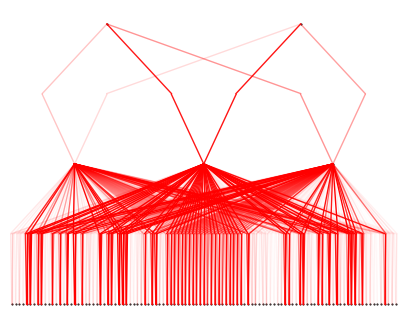

In [10]:
model.plot()